

# implement autoencoder



*a lil more about autoencoders :* 
![img](img/autoencoder.png)

The autoencoder tries to learn a function $h_{w,b}(x)≈x$. In other words, it is trying to learn an approximation to the identity function, so as to output $y$ that is similar to $x$. The identity function seems a particularly trivial function to be trying to learn; but by placing constraints on the network, such as by limiting the number of hidden units(the latent represntation), we can discover interesting structure about the data. As a concrete example, suppose the inputs $x$
are the pixel intensity values from a $10×10$ image ($100$ pixels) so n=100 and there are s2=50 hidden units in layer L2, Note that we also have $y∈ℜ^{100}$, Since there are only 50 hidden units, the network is forced to learn a "compressed” representation of the input. I.e., given only the vector of hidden unit activations $a(2)∈ℜ^{50}$, it must try to ”reconstruct” the $100$ pixel input $x$

If the input were completely random—say, each $x_i$ comes from an IID Gaussian independent of the other features—then this compression task would be very difficult. But if there is structure in the data, for example, if some of the input features are correlated, then this algorithm will be able to discover some of those correlations

In [53]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

> first i will implement vanila encoder with vanila NNs

```
# code to use later
from torchinfo import summary
summary(enc, (1,1,28,28), device='cuda')  # Print the model summary
```

In [61]:
# hyper parameters
LATENT_SPACE_DIM = 32
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
EPOCHS = 10

In [62]:
# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [63]:
class AE(nn.Module):
    def __init__(self, leaky = 0.01):
      super(AE, self).__init__()
      self.leaky = leaky

      # encoder -> compress to latent space
      self.encoder = nn.Sequential(
          nn.Flatten(),
          nn.Linear(28*28, 256),
          nn.LeakyReLU(leaky),
          nn.Linear(256, LATENT_SPACE_DIM),
          nn.ReLU(True)
      )

      # decoder -> reconstruction
      self.decoder = nn.Sequential(
          nn.Linear(LATENT_SPACE_DIM, 256),
          nn.LeakyReLU(leaky),
          nn.Linear(256, 28*28),
          nn.Sigmoid(),
          )

    def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      # [B, C, H, W]
      x = x.view(-1, 1, 28, 28)
      return x

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [65]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 0.0702
Epoch [2/10], Loss: 0.0365
Epoch [3/10], Loss: 0.0266
Epoch [4/10], Loss: 0.0210
Epoch [5/10], Loss: 0.0178
Epoch [6/10], Loss: 0.0157
Epoch [7/10], Loss: 0.0143
Epoch [8/10], Loss: 0.0134
Epoch [9/10], Loss: 0.0127
Epoch [10/10], Loss: 0.0121


In [66]:
model.eval()
with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        break  # Only visualize first batch

imgs = imgs.cpu().numpy()
outputs = outputs.cpu().numpy()

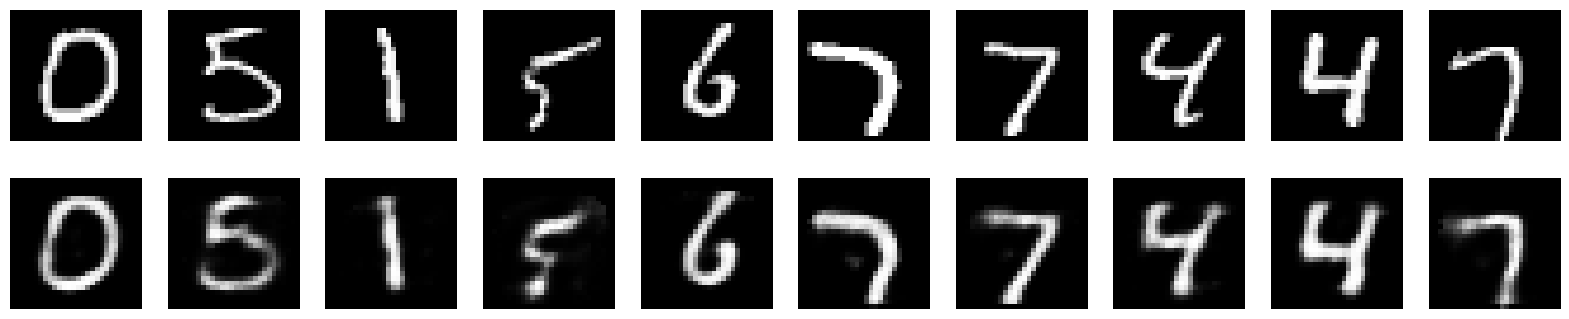

In [68]:
import numpy as np

n = 10
plt.figure(figsize=(20, 4))

# Get the batch size (number of images in imgs)
batch_size = imgs.shape[0]

# Randomly select n unique indices from the batch
random_indices = np.random.choice(batch_size, n, replace=False)

for i, idx in enumerate(random_indices):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs[idx].reshape(28, 28), cmap='gray')
    plt.axis('off')
    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(outputs[idx].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()


> now i will implement convulational AE

In [69]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), # [16, 14, 14]
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # [32, 7, 7]
            nn.ReLU(True),
            nn.Conv2d(32, LATENT_SPACE_DIM, kernel_size=7) # [LATENT_SPACE_DIM, 1, 1]
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(LATENT_SPACE_DIM, 32, kernel_size=7), # [32, 7, 7]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # [16, 14, 14]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # [1, 28, 28]
            nn.Sigmoid() # Output pixel values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [72]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 0.0843
Epoch [2/10], Loss: 0.0609
Epoch [3/10], Loss: 0.0293
Epoch [4/10], Loss: 0.0190
Epoch [5/10], Loss: 0.0150
Epoch [6/10], Loss: 0.0125
Epoch [7/10], Loss: 0.0110
Epoch [8/10], Loss: 0.0099
Epoch [9/10], Loss: 0.0091
Epoch [10/10], Loss: 0.0085


In [73]:
model.eval()
with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        break  # Only visualize first batch

imgs = imgs.cpu().numpy()
outputs = outputs.cpu().numpy()

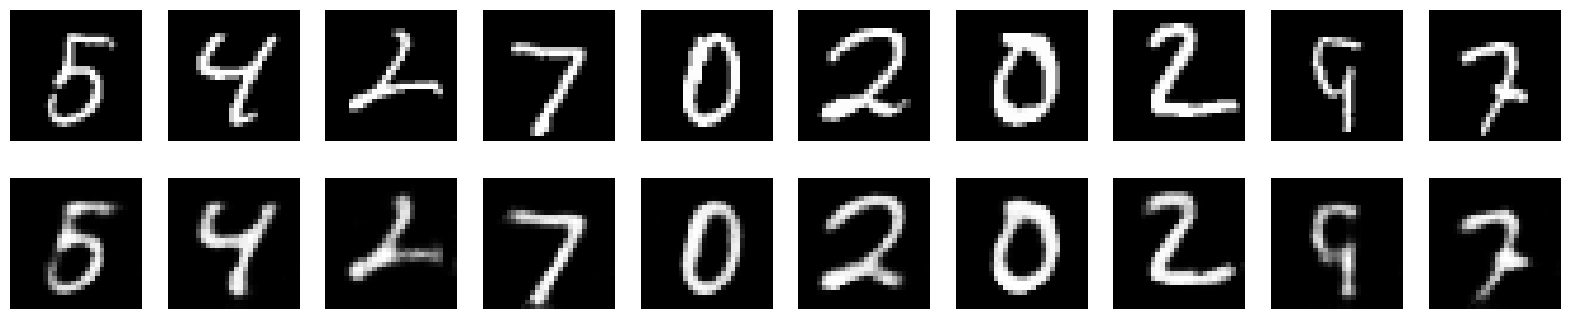

In [74]:
import numpy as np

n = 10
plt.figure(figsize=(20, 4))

# Get the batch size (number of images in imgs)
batch_size = imgs.shape[0]

# Randomly select n unique indices from the batch
random_indices = np.random.choice(batch_size, n, replace=False)

for i, idx in enumerate(random_indices):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs[idx].reshape(28, 28), cmap='gray')
    plt.axis('off')
    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(outputs[idx].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()